In [1]:
# importing necessary libraries
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
spy_stocklist = pd.read_csv(r'raw_data/sp_500_historical_components.csv')

# Data cleaning
In this portion of the code we will 
1) Get the list of stocks that ever existed from sp_500_historical_components.csv from https://github.com/hanshof/sp500_constituents/blob/main/sp_500_historical_components.csv and create membership index
2) Use yfinance library to get historical data (2012-2020) OHLCV, PE ratio, PB ratio from the lists of stocks, indicate their presence in the stock data at any point of time on a daily level. we get 2012 data for a buffer to calculate moving averages later on
3) Filter out stocks that newly entered the stock market before 2016, this is to ensure that we have sufficient training data for each stock

In [3]:

# Convert 'date' column to datetime
spy_stocklist['date'] = pd.to_datetime(spy_stocklist['date'])

# Ensure 'tickers' is string
spy_stocklist['tickers'] = spy_stocklist['tickers'].astype(str)
spy_stocklist

,date,tickers
0,1996-01-02,"AAL,AAMRQ,AAPL,ABI,ABS,ABT,ABX,ACKH,ACV,ADM,AD..."
1,1996-01-03,"AAL,AAMRQ,AAPL,ABI,ABS,ABT,ABX,ACKH,ACV,ADM,AD..."
2,1996-01-04,"AAL,AAMRQ,AAPL,ABI,ABS,ABT,ABX,ACKH,ACV,ADM,AD..."
3,1996-01-10,"AAL,AAMRQ,AAPL,ABI,ABS,ABT,ABX,ACKH,ACV,ADM,AD..."
4,1996-01-11,"AAL,AAMRQ,AAPL,ABI,ABS,ABT,ABX,ACKH,ACV,ADM,AD..."
...,...,...
3477,2025-08-19,"A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP..."
3478,2025-08-20,"A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP..."
3479,2025-08-21,"A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP..."
3480,2025-08-22,"A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP..."


In [4]:
spy_stocklist_filtered = spy_stocklist[(spy_stocklist['date'] >= '2013-01-01') & (spy_stocklist['date'] <= '2021-01-08')]

spy_stocklist_filtered

,date,tickers
1908,2013-01-02,"A,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,ADSK,..."
1909,2013-01-03,"A,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,ADSK,..."
1910,2013-01-08,"A,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,ADSK,..."
1911,2013-01-14,"A,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,ADSK,..."
1912,2013-01-15,"A,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,ADSK,..."
...,...,...
2625,2020-10-07,"A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,ADI,..."
2626,2020-10-12,"A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,ADI,..."
2627,2020-11-17,"A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,ADI,..."
2628,2020-12-21,"A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,ADI,..."


In [5]:
# Split the tickers into lists
spy_stocklist_filtered_expanded_unexploded = (
    spy_stocklist_filtered.assign(
        ticker=spy_stocklist_filtered["tickers"].str.split(",")
    )
    .drop(columns="tickers")
    .reset_index(drop=True)
)

# Apply mapping to each list of tickers
updated_ticker_mapping = {
    'GOOGL': 'GOOG',
    'FB': 'META',
    'TWTR': 'X',
}

spy_stocklist_filtered_expanded_unexploded["ticker"] = (
    spy_stocklist_filtered_expanded_unexploded["ticker"]
    .apply(lambda lst: [updated_ticker_mapping.get(t, t) for t in lst])
)


# Explode the lists into separate rows
spy_stocklist_filtered_expanded = (
    spy_stocklist_filtered_expanded_unexploded
    .explode("ticker")
    .reset_index(drop=True)
)

spy_stocklist_filtered_expanded 


,date,ticker
0,2013-01-02,A
1,2013-01-02,AAPL
2,2013-01-02,ABBV
3,2013-01-02,ABC
4,2013-01-02,ABT
...,...,...
344472,2021-01-07,YUM
344473,2021-01-07,ZBH
344474,2021-01-07,ZBRA
344475,2021-01-07,ZION


In [6]:
def get_monthly_survivors(df):
    df['year_month'] = df['date'].dt.to_period('M')
    
    # Get first date of each month
    month_starts = df.groupby('year_month')['date'].min().reset_index()
    month_starts.columns = ['year_month', 'start_date']
    
    results = []
    
    for i in range(len(month_starts) - 1):
        start = month_starts.loc[i, 'start_date']
        end = month_starts.loc[i + 1, 'start_date']

        # Filter month data
        month_df = df[(df['date'] >= start) & (df['date'] < end)]
        if month_df.empty:
            continue

        # All tickers ever observed in this month
        all_tickers = set().union(*month_df['ticker'])

        # Intersection across all days → surviving tickers
        surviving = set(month_df.iloc[0]['ticker'])
        for tickers in month_df['ticker']:
            surviving &= set(tickers)

        results.append({
            'date': start,
            'ticker_list': sorted(list(surviving)),
        })

    return pd.DataFrame(results)

survivors_df = get_monthly_survivors(spy_stocklist_filtered_expanded_unexploded)

# Convert 'date' to first day of the month and create 'month' column
survivors_df['month'] = survivors_df['date'].dt.to_period('M').dt.to_timestamp()
# Set 'month' as index
survivors_df.set_index('month', inplace=True)
# Create full month range
full_month_range = pd.date_range(start='2013-01-01', end='2020-12-31', freq='MS')
# Reindex to include all months 
survivors_df = survivors_df.reindex(full_month_range)

# Forward-fill missing months
survivors_df.ffill(inplace=True)
survivors_df = survivors_df.reset_index()
survivors_df.rename(columns={'index': 'month'}, inplace=True)

survivors_df

,month,date,ticker_list
0,2013-01-01,2013-01-02,"[A, AAPL, ABBV, ABC, ABT, ACN, ADBE, ADI, ADM,..."
1,2013-02-01,2013-02-04,"[A, AAPL, ABBV, ABC, ABT, ACN, ADBE, ADI, ADM,..."
2,2013-03-01,2013-03-11,"[A, AAPL, ABBV, ABC, ABT, ACN, ADBE, ADI, ADM,..."
3,2013-04-01,2013-04-01,"[A, AAPL, ABBV, ABC, ABT, ACN, ADBE, ADI, ADM,..."
4,2013-05-01,2013-05-01,"[A, AAPL, ABBV, ABC, ABT, ACN, ADBE, ADI, ADM,..."
...,...,...,...
91,2020-08-01,2020-06-22,"[A, AAL, AAP, AAPL, ABBV, ABC, ABMD, ABT, ACN,..."
92,2020-09-01,2020-09-18,"[A, AAL, AAP, AAPL, ABBV, ABC, ABMD, ABT, ACN,..."
93,2020-10-01,2020-10-07,"[A, AAL, AAP, AAPL, ABBV, ABC, ABMD, ABT, ACN,..."
94,2020-11-01,2020-11-17,"[A, AAL, AAP, AAPL, ABBV, ABC, ABMD, ABT, ACN,..."


In [7]:
### getting list of unique tickers that ever entered the SP500 between 2013-2020

spy_stocklist_final = spy_stocklist_filtered_expanded[
    (spy_stocklist_filtered_expanded['date'] >= '2013-01-01') &
    (spy_stocklist_filtered_expanded['date'] <= '2020-12-31')]

unique_tickers = spy_stocklist_final['ticker'].unique().tolist()
print(f"Total unique tickers in S&P 500 from 2013 to 2020: {len(unique_tickers)}")
unique_tickers

Total unique tickers in S&P 500 from 2013 to 2020: 639


['A',
 'AAPL',
 'ABBV',
 'ABC',
 'ABT',
 'ACN',
 'ADBE',
 'ADI',
 'ADM',
 'ADP',
 'ADSK',
 'AEE',
 'AEP',
 'AES',
 'AET',
 'AFL',
 'AIG',
 'AIV',
 'AIZ',
 'AKAM',
 'ALL',
 'ALXN',
 'AMAT',
 'AMD',
 'AMGN',
 'AMP',
 'AMT',
 'AMZN',
 'AN',
 'ANDV',
 'ANF',
 'ANTM',
 'AON',
 'APA',
 'APC',
 'APD',
 'APH',
 'APOL',
 'APTV',
 'ARG',
 'ATI',
 'AVB',
 'AVP',
 'AVY',
 'AXP',
 'AZO',
 'BA',
 'BAC',
 'BAX',
 'BBBY',
 'BBT',
 'BBY',
 'BCR',
 'BDX',
 'BEN',
 'BF-B',
 'BIG',
 'BIIB',
 'BK',
 'BKNG',
 'BLK',
 'BLL',
 'BMS',
 'BMY',
 'BRCM',
 'BRK-B',
 'BSX',
 'BTUUQ',
 'BWA',
 'BXP',
 'C',
 'CA',
 'CAG',
 'CAH',
 'CAM',
 'CAT',
 'CB',
 'CBRE',
 'CBS',
 'CCI',
 'CCL',
 'CELG',
 'CERN',
 'CF',
 'CFN',
 'CHRW',
 'CI',
 'CINF',
 'CL',
 'CLF',
 'CLX',
 'CMA',
 'CMCSA',
 'CME',
 'CMG',
 'CMI',
 'CMS',
 'CNP',
 'CNX',
 'COF',
 'COG',
 'COL',
 'COP',
 'COST',
 'COV',
 'CPB',
 'CRM',
 'CSCO',
 'CSX',
 'CTAS',
 'CTL',
 'CTSH',
 'CTXS',
 'CVC',
 'CVS',
 'CVX',
 'D',
 'DD',
 'DE',
 'DF',
 'DFS',
 'DG',
 'DGX',


In [8]:
### now we will use the yfinance library to get the historical data for these tickers that ever existed in the SP500 between 2013-2020
def get_stock_data(ticker, start_date, end_date):
    try:
        # Convert string to datetime so we can safely add 1 day, because yfinance end date is exclusive we add one day to include the end date
        end_date_dt = pd.to_datetime(end_date) + pd.Timedelta(days=1)
        
        stock = yf.Ticker(ticker)
        stock_data = stock.history(
            start=start_date,
            end=end_date_dt,
            auto_adjust=True,  # adjust for stock splits/dividends
            actions=True       # include Dividends and Stock Splits columns
        )
        
        if stock_data.empty:
            return pd.DataFrame()
        
        stock_data["ticker"] = ticker
        return stock_data.reset_index()

    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return pd.DataFrame()

In [9]:
start_date = '2012-01-01' # we start from 2012 to have a buffer for moving averages calculation
end_date = '2021-01-31' # we end at 2020-12-31, 2019-2020 will be held out for stress testing 
                        # 1 month additional buffer when we lead future expected returns predictino
yfinance_data = []
failed_tickers = []
successful_tickers = []
for ticker in unique_tickers:
    print(f"Fetching data for {ticker}...")
    ticker_data = get_stock_data(ticker, start_date, end_date)
    if not ticker_data.empty:
        yfinance_data.append(ticker_data)
        successful_tickers.append(ticker)
    else:
        failed_tickers.append(ticker)

    

Fetching data for A...
Fetching data for AAPL...
Fetching data for ABBV...
Fetching data for ABC...


$ABC: possibly delisted; no timezone found


Fetching data for ABT...
Fetching data for ACN...
Fetching data for ADBE...
Fetching data for ADI...
Fetching data for ADM...
Fetching data for ADP...
Fetching data for ADSK...
Fetching data for AEE...
Fetching data for AEP...
Fetching data for AES...
Fetching data for AET...
Fetching data for AFL...
Fetching data for AIG...
Fetching data for AIV...
Fetching data for AIZ...
Fetching data for AKAM...
Fetching data for ALL...
Fetching data for ALXN...


$ALXN: possibly delisted; no timezone found


Fetching data for AMAT...
Fetching data for AMD...
Fetching data for AMGN...
Fetching data for AMP...
Fetching data for AMT...
Fetching data for AMZN...
Fetching data for AN...
Fetching data for ANDV...
Fetching data for ANF...
Fetching data for ANTM...


$ANTM: possibly delisted; no timezone found


Fetching data for AON...
Fetching data for APA...
Fetching data for APC...


$APC: possibly delisted; no timezone found


Fetching data for APD...
Fetching data for APH...


$APOL: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00)
$ARG: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00)


Fetching data for APOL...
Fetching data for APTV...
Fetching data for ARG...
Fetching data for ATI...
Fetching data for AVB...
Fetching data for AVP...


$AVP: possibly delisted; no timezone found


Fetching data for AVY...
Fetching data for AXP...
Fetching data for AZO...
Fetching data for BA...
Fetching data for BAC...
Fetching data for BAX...
Fetching data for BBBY...
Fetching data for BBT...
Fetching data for BBY...


$BCR: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00)


Fetching data for BCR...
Fetching data for BDX...
Fetching data for BEN...
Fetching data for BF-B...
Fetching data for BIG...


$BIG: possibly delisted; no timezone found


Fetching data for BIIB...
Fetching data for BK...
Fetching data for BKNG...
Fetching data for BLK...
Fetching data for BLL...


$BLL: possibly delisted; no timezone found


Fetching data for BMS...
Fetching data for BMY...


$BRCM: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00)


Fetching data for BRCM...
Fetching data for BRK-B...
Fetching data for BSX...
Fetching data for BTUUQ...


$BTUUQ: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00)


Fetching data for BWA...
Fetching data for BXP...
Fetching data for C...
Fetching data for CA...


$CA: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325394000, endDate = 1612155600")


Fetching data for CAG...
Fetching data for CAH...
Fetching data for CAM...


$CAM: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325394000, endDate = 1612155600")


Fetching data for CAT...
Fetching data for CB...
Fetching data for CBRE...
Fetching data for CBS...


$CBS: possibly delisted; no timezone found


Fetching data for CCI...
Fetching data for CCL...
Fetching data for CELG...


$CELG: possibly delisted; no timezone found


Fetching data for CERN...


$CERN: possibly delisted; no timezone found
$CFN: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00)


Fetching data for CF...
Fetching data for CFN...
Fetching data for CHRW...
Fetching data for CI...
Fetching data for CINF...
Fetching data for CL...
Fetching data for CLF...
Fetching data for CLX...
Fetching data for CMA...
Fetching data for CMCSA...
Fetching data for CME...
Fetching data for CMG...
Fetching data for CMI...
Fetching data for CMS...
Fetching data for CNP...
Fetching data for CNX...
Fetching data for COF...
Fetching data for COG...


$COG: possibly delisted; no timezone found


Fetching data for COL...
Fetching data for COP...
Fetching data for COST...
Fetching data for COV...
Fetching data for CPB...
Fetching data for CRM...
Fetching data for CSCO...
Fetching data for CSX...
Fetching data for CTAS...
Fetching data for CTL...


$CTL: possibly delisted; no timezone found


Fetching data for CTSH...
Fetching data for CTXS...


$CTXS: possibly delisted; no timezone found
$CVC: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00)


Fetching data for CVC...
Fetching data for CVS...
Fetching data for CVX...
Fetching data for D...
Fetching data for DD...
Fetching data for DE...
Fetching data for DF...


$DF: possibly delisted; no timezone found


Fetching data for DFS...


$DFS: possibly delisted; no timezone found


Fetching data for DG...
Fetching data for DGX...
Fetching data for DHI...
Fetching data for DHR...
Fetching data for DIS...
Fetching data for DISCA...


$DISCA: possibly delisted; no timezone found


Fetching data for DLTR...
Fetching data for DNR...


$DNR: possibly delisted; no timezone found


Fetching data for DOV...
Fetching data for DRI...
Fetching data for DTE...
Fetching data for DUK...
Fetching data for DVA...
Fetching data for DVN...
Fetching data for DXC...
Fetching data for EA...
Fetching data for EBAY...
Fetching data for ECL...
Fetching data for ED...
Fetching data for EFX...
Fetching data for EIX...
Fetching data for EL...
Fetching data for EMN...
Fetching data for EMR...
Fetching data for EOG...
Fetching data for EQR...
Fetching data for EQT...
Fetching data for ES...
Fetching data for ESRX...
Fetching data for ESV...


$ESV: possibly delisted; no timezone found


Fetching data for ETFC...


$ETFC: possibly delisted; no timezone found


Fetching data for ETN...
Fetching data for ETR...
Fetching data for EW...
Fetching data for EXC...
Fetching data for EXPD...
Fetching data for EXPE...
Fetching data for F...
Fetching data for FAST...


$FDO: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00)


Fetching data for FCX...
Fetching data for FDO...
Fetching data for FDX...
Fetching data for FE...
Fetching data for FFIV...
Fetching data for FHN...
Fetching data for FIS...
Fetching data for FISV...


$FISV: possibly delisted; no timezone found


Fetching data for FITB...
Fetching data for FLIR...


$FLIR: possibly delisted; no timezone found


Fetching data for FLR...
Fetching data for FLS...
Fetching data for FMC...
Fetching data for FRX...


$FRX: possibly delisted; no timezone found


Fetching data for FSLR...
Fetching data for FTI...
Fetching data for FTR...


$FTR: possibly delisted; no timezone found


Fetching data for GD...
Fetching data for GE...
Fetching data for GHC...
Fetching data for GILD...
Fetching data for GIS...
Fetching data for GLW...
Fetching data for GME...
Fetching data for GNW...
Fetching data for GOOG...
Fetching data for GPC...
Fetching data for GPS...


$GPS: possibly delisted; no timezone found


Fetching data for GRMN...
Fetching data for GS...
Fetching data for GT...
Fetching data for GWW...
Fetching data for HAL...
Fetching data for HAS...
Fetching data for HBAN...


$HCBK: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00)


Fetching data for HCBK...
Fetching data for HD...
Fetching data for HES...


$HES: possibly delisted; no timezone found


Fetching data for HIG...
Fetching data for HNZ...
Fetching data for HOG...
Fetching data for HON...
Fetching data for HP...
Fetching data for HPQ...
Fetching data for HRB...
Fetching data for HRL...
Fetching data for HRS...


$HRS: possibly delisted; no timezone found
$HSP: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00)


Fetching data for HSP...
Fetching data for HST...
Fetching data for HSY...
Fetching data for HUM...
Fetching data for IBM...
Fetching data for ICE...
Fetching data for IFF...
Fetching data for IGT...


$IGT: possibly delisted; no timezone found


Fetching data for INTC...
Fetching data for INTU...
Fetching data for IP...
Fetching data for IPG...
Fetching data for IRM...
Fetching data for ISRG...
Fetching data for ITW...
Fetching data for IVZ...
Fetching data for JBL...
Fetching data for JCI...
Fetching data for JCP...


$JCP: possibly delisted; no timezone found


Fetching data for JEC...


$JEC: possibly delisted; no timezone found


Fetching data for JEF...
Fetching data for JNJ...
Fetching data for JNPR...


$JNPR: possibly delisted; no timezone found
$JOY: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00)


Fetching data for JOY...
Fetching data for JPM...
Fetching data for JWN...


$JWN: possibly delisted; no timezone found


Fetching data for K...
Fetching data for KDP...
Fetching data for KEY...
Fetching data for KIM...
Fetching data for KLAC...
Fetching data for KMB...
Fetching data for KMI...
Fetching data for KMX...
Fetching data for KO...
Fetching data for KR...


$KRFT: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00)


Fetching data for KRFT...
Fetching data for KSS...
Fetching data for L...
Fetching data for LB...


$LB: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325394000, endDate = 1612155600")


Fetching data for LDOS...
Fetching data for LEG...
Fetching data for LEN...
Fetching data for LH...


$LLTC: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00)


Fetching data for LLTC...
Fetching data for LLY...
Fetching data for LM...


$LM: possibly delisted; no timezone found


Fetching data for LMT...
Fetching data for LNC...
Fetching data for LO...


$LO: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00)


Fetching data for LOW...
Fetching data for LRCX...
Fetching data for LSI...


$LSI: possibly delisted; no timezone found


Fetching data for LUV...
Fetching data for LYB...
Fetching data for M...
Fetching data for MA...
Fetching data for MAR...
Fetching data for MAS...
Fetching data for MAT...
Fetching data for MCD...
Fetching data for MCHP...
Fetching data for MCK...
Fetching data for MCO...
Fetching data for MDLZ...
Fetching data for MDT...
Fetching data for MET...


$MJN: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00)


Fetching data for MJN...
Fetching data for MKC...
Fetching data for MMC...
Fetching data for MMM...
Fetching data for MNST...
Fetching data for MO...
Fetching data for MOLX...
Fetching data for MOS...
Fetching data for MPC...
Fetching data for MRK...
Fetching data for MRO...


$MRO: possibly delisted; no timezone found


Fetching data for MS...
Fetching data for MSFT...
Fetching data for MSI...
Fetching data for MTB...
Fetching data for MU...
Fetching data for MUR...


$MWV: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00)


Fetching data for MWV...
Fetching data for MYL...


$MYL: possibly delisted; no timezone found


Fetching data for NBL...


$NBL: possibly delisted; no timezone found


Fetching data for NBR...
Fetching data for NDAQ...
Fetching data for NEE...
Fetching data for NEM...
Fetching data for NFLX...
Fetching data for NFX...
Fetching data for NI...
Fetching data for NKE...
Fetching data for NOC...
Fetching data for NOV...
Fetching data for NRG...
Fetching data for NSC...
Fetching data for NTAP...
Fetching data for NTRS...
Fetching data for NUE...
Fetching data for NVDA...


$NYX: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00)


Fetching data for NWL...
Fetching data for NYX...
Fetching data for OI...
Fetching data for OKE...
Fetching data for OMC...
Fetching data for ORCL...
Fetching data for ORLY...
Fetching data for OXY...
Fetching data for PAYX...
Fetching data for PBCT...


$PBCT: possibly delisted; no timezone found


Fetching data for PBI...
Fetching data for PCAR...
Fetching data for PCG...
Fetching data for PDCO...


$PDCO: possibly delisted; no timezone found


Fetching data for PEG...
Fetching data for PEP...
Fetching data for PETM...
Fetching data for PFE...
Fetching data for PFG...
Fetching data for PG...
Fetching data for PGR...
Fetching data for PH...
Fetching data for PHM...
Fetching data for PKI...


$PKI: possibly delisted; no timezone found


Fetching data for PLD...
Fetching data for PM...
Fetching data for PNC...
Fetching data for PNR...
Fetching data for PNW...
Fetching data for PPG...
Fetching data for PPL...
Fetching data for PRGO...
Fetching data for PRU...
Fetching data for PSA...
Fetching data for PSX...
Fetching data for PWR...
Fetching data for PXD...


$PXD: possibly delisted; no timezone found


Fetching data for QCOM...
Fetching data for QEP...


$QEP: possibly delisted; no timezone found
$RAI: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00)


Fetching data for R...
Fetching data for RAI...
Fetching data for RDC...


$RDC: possibly delisted; no timezone found


Fetching data for RF...
Fetching data for RHI...
Fetching data for RHT...


$RHT: possibly delisted; no timezone found


Fetching data for RL...
Fetching data for ROK...
Fetching data for ROP...
Fetching data for ROST...
Fetching data for RRC...
Fetching data for RSG...
Fetching data for RTN...


$RTN: possibly delisted; no timezone found


Fetching data for SBUX...
Fetching data for SCG...
Fetching data for SCHW...
Fetching data for SEE...


$SIAL: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00)


Fetching data for SHW...
Fetching data for SIAL...
Fetching data for SJM...
Fetching data for SLB...
Fetching data for SLM...
Fetching data for SNA...
Fetching data for SNDK...


$SNDK: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325394000, endDate = 1612155600")
$SNI: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00)


Fetching data for SNI...
Fetching data for SO...
Fetching data for SPG...
Fetching data for SPGI...
Fetching data for SPLS...


$SPLS: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00)


Fetching data for SRCL...


$SRCL: possibly delisted; no timezone found


Fetching data for SRE...
Fetching data for STI...


$STI: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325394000, endDate = 1612155600")
$STJ: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00)


Fetching data for STJ...
Fetching data for STT...
Fetching data for STX...
Fetching data for STZ...
Fetching data for SWK...
Fetching data for SWN...


$SWN: possibly delisted; no timezone found
$SWY: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00)


Fetching data for SWY...
Fetching data for SYK...
Fetching data for SYMC...


$SYMC: possibly delisted; no timezone found


Fetching data for SYY...
Fetching data for T...
Fetching data for TAP...
Fetching data for TDC...
Fetching data for TE...
Fetching data for TEL...
Fetching data for TER...
Fetching data for TGNA...
Fetching data for TGT...
Fetching data for THC...
Fetching data for TIF...


$TIF: possibly delisted; no timezone found


Fetching data for TJX...
Fetching data for TMK...


$TMK: possibly delisted; no timezone found


Fetching data for TMO...
Fetching data for TMUS...
Fetching data for TPR...
Fetching data for TRIP...
Fetching data for TROW...
Fetching data for TRV...
Fetching data for TSN...
Fetching data for TSS...


$TSS: possibly delisted; no timezone found
$TWC: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00)


Fetching data for TWC...
Fetching data for TWX...
Fetching data for TXN...
Fetching data for TXT...
Fetching data for UNH...
Fetching data for UNM...
Fetching data for UNP...
Fetching data for UPS...
Fetching data for USB...
Fetching data for UTX...


$UTX: possibly delisted; no timezone found


Fetching data for V...
Fetching data for VAR...


$VAR: possibly delisted; no timezone found


Fetching data for VFC...
Fetching data for VIAB...


$VIAB: possibly delisted; no timezone found


Fetching data for VIAV...
Fetching data for VLO...
Fetching data for VMC...
Fetching data for VNO...
Fetching data for VRSN...
Fetching data for VTR...
Fetching data for VZ...
Fetching data for WAT...
Fetching data for WBA...


$WBA: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00) (Yahoo error = "No data found, symbol may be delisted")


Fetching data for WDC...
Fetching data for WEC...
Fetching data for WELL...
Fetching data for WFC...


$WFM: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00)


Fetching data for WFM...
Fetching data for WHR...
Fetching data for WIN...


$WIN: possibly delisted; no timezone found


Fetching data for WM...
Fetching data for WMB...
Fetching data for WMT...
Fetching data for WPX...


$WPX: possibly delisted; no timezone found


Fetching data for WU...
Fetching data for WY...
Fetching data for WYNN...
Fetching data for X...


$X: possibly delisted; no timezone found


Fetching data for XEL...
Fetching data for XLNX...


$XLNX: possibly delisted; no timezone found


Fetching data for XOM...
Fetching data for XRAY...
Fetching data for XRX...
Fetching data for XYL...
Fetching data for YUM...
Fetching data for ZBH...
Fetching data for ZION...
Fetching data for PVH...
Fetching data for REGN...
Fetching data for MAC...
Fetching data for KSU...


$KSU: possibly delisted; no timezone found


Fetching data for GM...
Fetching data for ZTS...
Fetching data for NWSA...
Fetching data for NLSN...


$NLSN: possibly delisted; no timezone found


Fetching data for DAL...
Fetching data for AME...


$KORS: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00)


Fetching data for VRTX...
Fetching data for KORS...
Fetching data for ALLE...


$GGP: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00)


Fetching data for GGP...
Fetching data for ADS...


$ADS: possibly delisted; no timezone found


Fetching data for META...
Fetching data for MHK...
Fetching data for TSCO...


$GMCR: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00)


Fetching data for GMCR...
Fetching data for ESS...
Fetching data for NAVI...
Fetching data for UAA...
Fetching data for AVGO...
Fetching data for XEC...


$XEC: possibly delisted; no timezone found


Fetching data for AMG...
Fetching data for MLM...
Fetching data for DISCK...


$DISCK: possibly delisted; no timezone found


Fetching data for UHS...
Fetching data for URI...


$LVLT: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00)


Fetching data for LVLT...
Fetching data for RCL...
Fetching data for ENDP...


$ENDP: possibly delisted; no timezone found


Fetching data for HCA...
Fetching data for SWKS...
Fetching data for HSIC...
Fetching data for AAL...
Fetching data for EQIX...
Fetching data for HBI...
Fetching data for SLG...
Fetching data for O...
Fetching data for QRVO...


$BXLT: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00)


Fetching data for BXLT...
Fetching data for JBHT...
Fetching data for CPGX...


$CPGX: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00)


Fetching data for WRK...


$WRK: possibly delisted; no timezone found


Fetching data for KHC...
Fetching data for AAP...
Fetching data for PYPL...
Fetching data for ATVI...


$ATVI: possibly delisted; no timezone found
$CMCSK: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00)


Fetching data for UAL...
Fetching data for CMCSK...
Fetching data for NWS...
Fetching data for VRSK...
Fetching data for HPE...
Fetching data for FCPT...
Fetching data for SYF...
Fetching data for ILMN...
Fetching data for CSRA...
Fetching data for CHD...
Fetching data for CPRI...
Fetching data for WLTW...


$WLTW: possibly delisted; no timezone found


Fetching data for EXR...
Fetching data for CFG...
Fetching data for FRT...
Fetching data for CXO...


$CXO: possibly delisted; no timezone found


Fetching data for AWK...
Fetching data for UDR...
Fetching data for CNC...
Fetching data for HOLX...
Fetching data for FL...
Fetching data for UA...
Fetching data for ULTA...
Fetching data for GPN...
Fetching data for AYI...
Fetching data for ALK...
Fetching data for DLR...
Fetching data for LKQ...
Fetching data for AJG...
Fetching data for TDG...
Fetching data for FBHS...


$FBHS: possibly delisted; no timezone found


Fetching data for ALB...
Fetching data for LNT...
Fetching data for FTV...
Fetching data for MTD...
Fetching data for CHTR...
Fetching data for COO...
Fetching data for COTY...
Fetching data for EVHC...
Fetching data for MAA...
Fetching data for IDXX...
Fetching data for INCY...
Fetching data for CBOE...
Fetching data for REG...
Fetching data for DISH...


$DISH: possibly delisted; no timezone found


Fetching data for SNPS...
Fetching data for ARE...
Fetching data for RJF...
Fetching data for IT...
Fetching data for INFO...


$INFO: possibly delisted; no price data found  (1d 2012-01-01 -> 2021-02-01 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1325394000, endDate = 1612155600")


Fetching data for ALGN...
Fetching data for ANSS...


$ANSS: possibly delisted; no timezone found


Fetching data for HLT...
Fetching data for RE...


$RE: possibly delisted; no timezone found


Fetching data for AOS...
Fetching data for DRE...


$DRE: possibly delisted; no timezone found


Fetching data for MGM...
Fetching data for PKG...
Fetching data for RMD...
Fetching data for BHF...
Fetching data for IQV...
Fetching data for DWDP...


$DWDP: possibly delisted; no timezone found


Fetching data for SBAC...
Fetching data for CDNS...
Fetching data for NCLH...
Fetching data for HII...
Fetching data for IPGP...
Fetching data for NKTR...
Fetching data for SIVB...


$SIVB: possibly delisted; no timezone found


Fetching data for TTWO...
Fetching data for MSCI...
Fetching data for ABMD...


$ABMD: possibly delisted; no timezone found


Fetching data for EVRG...
Fetching data for BR...
Fetching data for HFC...


$HFC: possibly delisted; no timezone found


Fetching data for FLT...


$FLT: possibly delisted; no timezone found


Fetching data for CPRT...
Fetching data for ANET...
Fetching data for WCG...


$WCG: possibly delisted; no timezone found


Fetching data for ROL...
Fetching data for FTNT...
Fetching data for KEYS...
Fetching data for LIN...
Fetching data for JKHY...
Fetching data for FANG...
Fetching data for LW...
Fetching data for MXIM...


$MXIM: possibly delisted; no timezone found


Fetching data for CE...
Fetching data for FRC...


$FRC: possibly delisted; no timezone found


Fetching data for TFX...
Fetching data for ATO...
Fetching data for WAB...
Fetching data for LHX...
Fetching data for CTVA...
Fetching data for AMCR...
Fetching data for MKTX...
Fetching data for GL...
Fetching data for IEX...
Fetching data for CDW...
Fetching data for NVR...
Fetching data for LVS...
Fetching data for BKR...
Fetching data for NLOK...


$NLOK: possibly delisted; no timezone found


Fetching data for PEAK...


$PEAK: possibly delisted; no timezone found


Fetching data for NOW...
Fetching data for VIAC...


$VIAC: possibly delisted; no timezone found


Fetching data for WRB...
Fetching data for ODFL...
Fetching data for TFC...
Fetching data for J...
Fetching data for LYV...
Fetching data for STE...
Fetching data for ZBRA...
Fetching data for PAYC...
Fetching data for TT...
Fetching data for CARR...
Fetching data for OTIS...
Fetching data for RTX...
Fetching data for HWM...
Fetching data for DPZ...
Fetching data for DXCM...
Fetching data for WST...
Fetching data for BIO...
Fetching data for TDY...
Fetching data for TYL...
Fetching data for LUMN...
Fetching data for CTLT...


$CTLT: possibly delisted; no timezone found


Fetching data for ETSY...
Fetching data for POOL...
Fetching data for VNT...
Fetching data for VTRS...
Fetching data for TSLA...


In [10]:
# combine all individual DataFrames into one big DataFrame
yfinance_df = pd.concat(yfinance_data, ignore_index=True)
yfinance_df["Date"] = pd.to_datetime(yfinance_df["Date"])

# preview result
yfinance_df.drop(columns=['Capital Gains'], inplace=True)
yfinance_df['Date'] = yfinance_df['Date'].dt.tz_localize(None)

yfinance_df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker
0,2012-01-03,22.776923,23.507767,22.713371,23.183655,4156394,0.0,0.0,A
1,2012-01-04,22.973938,23.107396,22.618048,22.999357,4651845,0.0,0.0,A
2,2012-01-05,22.802344,23.717488,22.700662,23.514124,6842651,0.0,0.0,A
3,2012-01-06,23.571324,23.870017,23.393380,23.768335,4711400,0.0,0.0,A
4,2012-01-09,23.908145,24.416559,23.812817,24.391138,4429563,0.0,0.0,A
...,...,...,...,...,...,...,...,...,...
1136346,2021-01-25,285.000000,300.133331,279.606659,293.600006,123520200,0.0,0.0,TSLA
1136347,2021-01-26,297.126678,298.633331,290.533325,294.363342,69394800,0.0,0.0,TSLA
1136348,2021-01-27,290.116669,297.166656,286.220001,288.053345,82002000,0.0,0.0,TSLA
1136349,2021-01-28,273.333344,282.666656,267.000000,278.476654,79134000,0.0,0.0,TSLA


In [11]:
# checking for stock split price adjustment, for example apple, check the dates around 2020-08-31 when apple had a 4-for-1 stock split
yfinance_df[yfinance_df['Date'].between('2020-08-24', '2020-09-07') & (yfinance_df['ticker'] == 'AAPL')]

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker
4458,2020-08-24,125.186351,125.271473,120.556219,122.423836,345937600,0.0,0.0,AAPL
4459,2020-08-25,121.295478,121.764813,119.695353,121.419495,211495600,0.0,0.0,AAPL
4460,2020-08-26,122.737524,123.527857,121.669963,123.070679,163022400,0.0,0.0,AAPL
4461,2020-08-27,123.673785,124.006940,120.454084,121.599464,155552400,0.0,0.0,AAPL
4462,2020-08-28,122.574593,122.992862,121.178745,121.402473,187630000,0.0,0.0,AAPL
4463,2020-08-31,124.099318,127.426011,122.562423,125.519478,225702700,0.0,4.0,AAPL
4464,2020-09-01,129.138014,131.122367,126.968858,130.519272,151948100,0.0,0.0,AAPL
4465,2020-09-02,133.836211,134.215570,123.535135,127.815086,200119000,0.0,0.0,AAPL
4466,2020-09-03,123.447601,125.324939,117.212478,117.582108,257599600,0.0,0.0,AAPL
4467,2020-09-04,116.794217,120.325179,107.864668,117.659935,332607200,0.0,0.0,AAPL


In [12]:
#Membership Indicator 

# Create 'month' column 
yfinance_df['month'] = yfinance_df['Date'].dt.to_period('M').dt.to_timestamp()

# Merge with survivors_df on 'month'
merged_df = yfinance_df.merge(
    survivors_df[['month', 'ticker_list']],
    on='month',
    how='left'
)

# Check if ticker is in ticker_list for that month, 1 if yes, 0 if no
merged_df['is_in_sp500'] = merged_df.apply(
    lambda row: int(row['ticker'] in row['ticker_list']) if isinstance(row['ticker_list'], (list, set)) else 0,
    axis=1
)



merged_df.drop(columns=['ticker_list', 'month'], inplace=True)


In [13]:
#just to check
merged_df[merged_df['ticker'] == 'TSLA'].tail(25)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,is_in_sp500
1136326,2020-12-23,210.733337,217.166672,207.523331,215.326660,99519000,0.0,0.0,TSLA,1
1136327,2020-12-24,214.330002,222.029999,213.666672,220.589996,68596800,0.0,0.0,TSLA,1
1136328,2020-12-28,224.836670,227.133331,220.266663,221.229996,96835800,0.0,0.0,TSLA,1
1136329,2020-12-29,220.333328,223.300003,218.333328,221.996674,68732400,0.0,0.0,TSLA,1
1136330,2020-12-30,224.000000,232.199997,222.786667,231.593338,128538000,0.0,0.0,TSLA,1
1136331,2020-12-31,233.330002,239.573334,230.373337,235.223328,148949700,0.0,0.0,TSLA,1
1136332,2021-01-04,239.820007,248.163330,239.063339,243.256668,145914600,0.0,0.0,TSLA,0
1136333,2021-01-05,241.220001,246.946671,239.733337,245.036667,96735600,0.0,0.0,TSLA,0
1136334,2021-01-06,252.830002,258.000000,249.699997,251.993332,134100000,0.0,0.0,TSLA,0
1136335,2021-01-07,259.209991,272.329987,258.399994,272.013336,154496700,0.0,0.0,TSLA,0


In [14]:
# filtering stocks that entered the stock market after 2016-01-01 to ensure we have enough training data per stock

yfinance_df = merged_df
first_trade = yfinance_df.groupby("ticker")["Date"].min().reset_index()
first_trade["Date"] = pd.to_datetime(first_trade["Date"])
first_trade.columns = ["ticker", "first_trade_date"]

# keep only tickers that started before or on 2015-12-31
eligible_tickers = first_trade[first_trade["first_trade_date"] <= "2015-12-31"]["ticker"]

yfinance_df_filtered_relavant_stocks = filtered_df = yfinance_df[yfinance_df["ticker"].isin(eligible_tickers)].copy()


print(f"Total tickers after filtering: {eligible_tickers.nunique()}, tickers filtered out: {len(unique_tickers) - eligible_tickers.nunique()}")

Total tickers after filtering: 505, tickers filtered out: 134


In [15]:
# getting daily returns, monthly returns and adding to the dataframe
# we take 21 trading days as approximately 1 month

yfinance_df_filtered_relavant_stocks.sort_values(by=['ticker', 'Date'], inplace=True)

# Compute log returns within each ticker group
yfinance_df_filtered_relavant_stocks['daily_log_return'] = (
    yfinance_df_filtered_relavant_stocks
    .groupby('ticker')['Close']
    .transform(lambda x: np.log(x / x.shift(1)))
)

# Compute log volume change within each ticker group
yfinance_df_filtered_relavant_stocks['daily_volume_return'] = (
    yfinance_df_filtered_relavant_stocks
    .groupby('ticker')['Volume']
    .transform(lambda x: np.log(x / x.shift(1)))
)

# Approx. 21 trading days ≈ 1 month
yfinance_df_filtered_relavant_stocks['monthly_log_return'] = (
    yfinance_df_filtered_relavant_stocks
    .groupby('ticker')['Close']
    .transform(lambda x: np.log(x / x.shift(21)))
)

# Lagged features: 11 lags of the past 21-day return, per ticker
for k in range(1, 12):
    yfinance_df_filtered_relavant_stocks[f'lag_{k}'] = yfinance_df_filtered_relavant_stocks.groupby('ticker')['monthly_log_return'].shift(k)



## future volatility 
yfinance_df_filtered_relavant_stocks['monthly_log_return_future'] = (
    yfinance_df_filtered_relavant_stocks
    .groupby('ticker')['Close']
    .transform(lambda x: np.log(x.shift(-21) / x))
    
)

feature_cols = [f'lag_{k}' for k in range(1, 12)]
df_model = yfinance_df_filtered_relavant_stocks.dropna(subset=['monthly_log_return_future'] + feature_cols)

/Users/ash/Documents/School/Y4S1/DSE4212/project/DSE4212-Portfolio-Optimiser/.venv/lib/python3.14/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [16]:
# getting monthly standard deviation (volatility) (TODO)
yfinance_df_filtered_relavant_stocks["monthly_var_3"] = (
    yfinance_df_filtered_relavant_stocks.groupby("ticker")["monthly_log_return"]
      .transform(lambda x: x.rolling(window=3, min_periods=3).var(ddof=1))
)

yfinance_df_filtered_relavant_stocks["daily_vol_21"] = (
    yfinance_df_filtered_relavant_stocks
    .groupby("ticker")["daily_log_return"]
    .transform(lambda x: x.rolling(window=21, min_periods=21).std(ddof=1))
)

In [17]:
# Clean the Dividends column
yfinance_df_filtered_relavant_stocks['Dividends'] = (
    yfinance_df_filtered_relavant_stocks['Dividends']
    .astype(str)                                # Ensure it's treated as string
    .str.replace('[^\\d.]', '', regex=True)      # Remove all except digits and decimal points
    .replace('', np.nan)                        # Replace empty strings with NaN
    .astype(float)                              # Convert to numeric
)


yfinance_df_filtered_relavant_stocks[yfinance_df_filtered_relavant_stocks['Dividends'] != 0]

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,is_in_sp500,...,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,monthly_log_return_future,monthly_var_3,daily_vol_21
61,2012-03-30,28.509856,28.573553,28.025776,28.350620,3246715,0.071531,0.0,A,0,...,0.020295,0.022910,0.048332,0.038427,0.034312,0.044372,0.046416,-0.035212,0.000037,0.017006
124,2012-06-29,24.491944,25.098653,24.491944,25.060335,3698828,0.071531,0.0,A,0,...,-0.043616,-0.034421,0.016123,0.060609,0.013036,0.006268,-0.029053,-0.024508,0.001229,0.024689
187,2012-09-28,24.638840,24.728483,24.203435,24.619631,6803367,0.071531,0.0,A,0,...,0.040288,0.055017,0.083644,0.060720,0.064623,-0.018702,-0.053518,-0.066118,0.000119,0.013467
247,2012-12-27,26.201215,26.246145,25.681297,26.085678,2823680,0.071531,0.0,A,0,...,0.078914,0.144812,0.130660,0.097722,0.091223,0.095508,0.072868,0.093878,0.000138,0.014328
309,2013-03-28,27.087203,27.087203,26.713853,27.016396,3002904,0.085837,0.0,A,1,...,-0.014067,-0.007234,-0.005935,-0.046605,-0.039659,-0.029568,-0.036534,-0.012226,0.000093,0.010986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843515,2020-01-16,132.115900,132.706124,131.392400,132.553818,1822800,0.200000,0.0,ZTS,1,...,0.108030,0.090804,0.106293,0.106003,0.107135,0.112143,0.093634,0.031180,0.000027,0.008384
843577,2020-04-16,119.399905,122.098371,118.217541,121.526253,2064000,0.200000,0.0,ZTS,1,...,-0.042088,-0.028224,-0.077814,-0.196960,-0.213322,-0.203947,-0.165772,0.000314,0.005133,0.053277
843640,2020-07-16,136.162641,136.506391,135.083648,136.487289,942000,0.200000,0.0,ZTS,1,...,-0.008102,-0.017779,-0.018394,-0.013758,-0.034765,-0.030791,-0.009441,0.094139,0.000163,0.013131
843707,2020-10-20,153.236110,154.440731,152.127086,152.672043,2145700,0.200000,0.0,ZTS,1,...,0.027349,0.060910,0.045321,0.026454,0.040846,0.026855,0.028862,0.023578,0.000211,0.012671


In [18]:
yfinance_df_filtered_relavant_stocks['Dividends'].astype(float)

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
843772    0.0
843773    0.0
843774    0.0
843775    0.0
843776    0.0
Name: Dividends, Length: 1129737, dtype: float64

### New stocks that entered after our 2013 cut off
the problem with these stocks is that they might not have enough historical data to compute fields such as:
1) monthly returns
2) monthly variance (3 months)
3) EMA/SMA

In [19]:
start_date = pd.Timestamp("2013-01-01")

# ensure Date is Timestamp
yfinance_df_filtered_relavant_stocks["Date"] = pd.to_datetime(yfinance_df_filtered_relavant_stocks["Date"])

# find earliest date per ticker
first_dates = (
    yfinance_df_filtered_relavant_stocks
    .groupby("ticker")["Date"]
    .min()
    .reset_index(name="first_date")
)

# flag tickers that started trading after 2013-01-01
first_dates["entered_after_2013"] = (first_dates["first_date"] > start_date).astype(int)

# count and preview
num_after = first_dates["entered_after_2013"].sum()
num_total = len(first_dates)

print(f"{num_after} out of {num_total} tickers started trading after {start_date.date()} before 2015-12-31.")
print(first_dates.query("entered_after_2013 == 1").head())




25 out of 505 tickers started trading after 2013-01-01 before 2015-12-31.
   ticker first_date  entered_after_2013
4    ABBV 2013-01-02                   1
26   ALLE 2013-11-18                   1
38   ANET 2014-06-06                   1
88    CDW 2013-06-27                   1
91    CFG 2014-09-24                   1


### Creating new features
#### Moving averages
https://www.investopedia.com/ask/answers/122414/what-are-most-common-periods-used-creating-moving-average-ma-lines.asp we will use short:20 days, medium: 50 days, long: 100 days moving averages
1) Simple moving average SMA: SMA_20, SMA_50, SMA_100
2) Exponential Moving Average EMA https://www.investopedia.com/terms/e/ema.asp#toc-formula-for-exponential-moving-average-ema: EMA_20, EMA_50, EMA_100

#### RSI and MACD
1) Relative Strength Index 14 days https://www.investopedia.com/terms/r/rsi.asp : RSI
2) Moving Average Convergence/Divergence indicator: https://www.investopedia.com/terms/m/macd.asp: MACD_26, MACD_12, MACD_9 

#### Stock Splits
1) Forward stock split (Stock split > 1): Commonly known as a bullish indicator which provides more liquidity (when fractional shares werent common)
2) Reverse stock split (0 < Stock split < 1): Bearish indicator

In [20]:
def sma(series: pd.Series, window: int) -> pd.Series:
    """Simple Moving Average."""
    return series.rolling(window, min_periods=window).mean()

In [21]:
def ema(series: pd.Series, span: int) -> pd.Series:
    """Exponential Moving Average."""
    return series.ewm(span=span, adjust=False, min_periods=span).mean()

In [22]:
def rsi_wilder(series: pd.Series, period: int = 14) -> pd.Series:
    """Wilder's RSI (default 14)."""
    delta = series.diff()
    gain  = delta.clip(lower=0)
    loss  = -delta.clip(upper=0)
    avg_gain = gain.ewm(alpha=1/period, adjust=False, min_periods=period).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False, min_periods=period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

In [23]:
def macd(series: pd.Series, fast: int = 12, slow: int = 26, signal: int = 9):
    """
    MACD parts: returns DataFrame with MACD_Line, MACD_Signal, MACD_Hist.
    """
    ema_fast = ema(series, fast)
    ema_slow = ema(series, slow)
    macd_line = ema_fast - ema_slow
    macd_signal = macd_line.ewm(span=signal, adjust=False, min_periods=signal).mean()
    macd_hist = macd_line - macd_signal
    return pd.DataFrame(
        {"MACD_Line": macd_line, "MACD_Signal": macd_signal, "MACD_Hist": macd_hist},
        index=series.index
    )

In [24]:
temp_df = yfinance_df_filtered_relavant_stocks.copy()

# Ensure types/order; compute per-ticker
temp_df['Date'] = pd.to_datetime(temp_df['Date'])
temp_df = temp_df.drop_duplicates(subset=['ticker','Date']).sort_values(['ticker','Date'])


g = temp_df.groupby('ticker', group_keys=False)

# SMA 20/50/100
for w in [20, 50, 100]:
    temp_df[f'SMA_{w}'] = g['Close'].transform(lambda s, w=w: sma(s, w))

# EMA 20/50/100
for w in [20, 50, 100]:
    temp_df[f'EMA_{w}'] = g['Close'].transform(lambda s, w=w: ema(s, w))

# RSI 14
temp_df['RSI'] = g['Close'].transform(rsi_wilder)

# MACD (12,26,9)
macd_df = g['Close'].apply(macd)
temp_df = temp_df.join(macd_df)

# Stock Splits
temp_df["forward_split"] = yfinance_df["Stock Splits"].apply(
    lambda x: x if x > 1 else 0
)
temp_df["reverse_split"] = yfinance_df["Stock Splits"].apply(
    lambda x: 1 / x if 0 < x < 1 else 0
)

SP500_all_stock_data = temp_df


SP500_all_stock_data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,is_in_sp500,...,SMA_100,EMA_20,EMA_50,EMA_100,RSI,MACD_Line,MACD_Signal,MACD_Hist,forward_split,reverse_split
0,2012-01-03,22.776923,23.507767,22.713371,23.183655,4156394,0.0,0.0,A,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1,2012-01-04,22.973938,23.107396,22.618048,22.999357,4651845,0.0,0.0,A,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,2012-01-05,22.802344,23.717488,22.700662,23.514124,6842651,0.0,0.0,A,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,2012-01-06,23.571324,23.870017,23.393380,23.768335,4711400,0.0,0.0,A,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,2012-01-09,23.908145,24.416559,23.812817,24.391138,4429563,0.0,0.0,A,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843772,2021-01-25,155.656733,156.259984,153.617181,154.488541,1443800,0.0,0.0,ZTS,0,...,155.222244,156.295390,155.637352,153.027196,45.446938,0.128775,0.473246,-0.344471,0.0,0.0
843773,2021-01-26,154.498136,154.775814,151.826607,152.927780,1982000,0.0,0.0,ZTS,0,...,155.204175,155.974665,155.531094,153.025227,41.893529,-0.150767,0.348444,-0.499211,0.0,0.0
843774,2021-01-27,151.280808,151.558486,146.071820,146.646332,2235600,0.0,0.0,ZTS,0,...,155.091973,155.086252,155.182672,152.898913,31.289929,-0.869148,0.104925,-0.974073,0.0,0.0
843775,2021-01-28,147.747531,153.827864,147.699651,149.882828,1859300,0.0,0.0,ZTS,0,...,155.074488,154.590688,154.974835,152.839188,39.751527,-1.163895,-0.148839,-1.015057,0.0,0.0


In [25]:
# for daily prices we use spreads instead of absolute prices
SP500_all_stock_data['high_low_spread'] = (SP500_all_stock_data['High'] - SP500_all_stock_data['Low'])/SP500_all_stock_data['Close']
SP500_all_stock_data['open_close_spread'] = (SP500_all_stock_data['Open'] - SP500_all_stock_data['Close'])/SP500_all_stock_data['Close']


In [26]:
# filter for stocks from 2013-01-01 onwards and before 2020-12-31

SP500_all_stock_data_final = SP500_all_stock_data[
    (SP500_all_stock_data['Date'] >= pd.to_datetime('2013-01-01')) &
    (SP500_all_stock_data['Date'] <= pd.to_datetime('2020-12-31'))
]

SP500_all_stock_data_final

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,is_in_sp500,...,EMA_50,EMA_100,RSI,MACD_Line,MACD_Signal,MACD_Hist,forward_split,reverse_split,high_low_spread,open_close_spread
250,2013-01-02,27.067743,27.067743,26.413034,26.881601,8790205,0.0,0.0,A,1,...,24.966328,24.735125,64.959762,0.571168,0.559054,0.012114,0.0,0.0,0.024355,0.006924
251,2013-01-03,26.920115,27.048490,26.689041,26.977884,5751791,0.0,0.0,A,1,...,25.045213,24.779536,65.650193,0.602699,0.567783,0.034916,0.0,0.0,0.013324,-0.002141
252,2013-01-04,27.048488,27.568405,26.868764,27.510635,6432897,0.0,0.0,A,1,...,25.141896,24.833617,69.259498,0.663033,0.586833,0.076199,0.0,0.0,0.025432,-0.016799
253,2013-01-07,27.343746,27.472121,27.202534,27.311653,3589505,0.0,0.0,A,1,...,25.226984,24.882687,66.450991,0.686873,0.606841,0.080032,0.0,0.0,0.009871,0.001175
254,2013-01-08,27.260303,27.459284,27.022810,27.093416,3896925,0.0,0.0,A,1,...,25.300178,24.926464,63.413758,0.680315,0.621536,0.058779,0.0,0.0,0.016110,0.006160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843753,2020-12-24,152.891909,154.756208,152.824993,153.656754,417400,0.0,0.0,ZTS,1,...,154.126828,151.172940,48.711798,-0.297335,-0.512990,0.215655,0.0,0.0,0.012568,-0.004978
843754,2020-12-28,154.345125,155.674038,153.264781,155.253372,1522400,0.0,0.0,ZTS,1,...,154.171006,151.253741,52.813414,-0.160016,-0.442395,0.282379,0.0,0.0,0.015518,-0.005850
843755,2020-12-29,156.037258,157.844196,155.262844,155.951202,1188400,0.0,0.0,ZTS,1,...,154.240818,151.346760,54.525170,0.005061,-0.352904,0.357965,0.0,0.0,0.016552,0.000552
843756,2020-12-30,156.324126,157.557442,155.989517,157.050735,1009000,0.0,0.0,ZTS,1,...,154.351010,151.459710,57.162078,0.222049,-0.237913,0.459963,0.0,0.0,0.009984,-0.004627


In [27]:
SP500_all_stock_data_final.isna().sum()

Date                            0
Open                            0
High                            0
Low                             0
Close                           0
Volume                          0
Dividends                       0
Stock Splits                    0
ticker                          0
is_in_sp500                     0
daily_log_return               25
daily_volume_return          3511
monthly_log_return            525
lag_1                         550
lag_2                         575
lag_3                         600
lag_4                         625
lag_5                         650
lag_6                         675
lag_7                         700
lag_8                         725
lag_9                         750
lag_10                        775
lag_11                        800
monthly_log_return_future    1238
monthly_var_3                 575
daily_vol_21                  525
SMA_20                        475
SMA_50                       1225
SMA_100       

In [28]:
# pruning new stocks with insufficient data to compute the fields
SP500_all_stock_data_final = SP500_all_stock_data_final.dropna()
len(SP500_all_stock_data_final)

993973

In [29]:
SP500_all_stock_data_final.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'ticker', 'is_in_sp500', 'daily_log_return',
       'daily_volume_return', 'monthly_log_return', 'lag_1', 'lag_2', 'lag_3',
       'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10',
       'lag_11', 'monthly_log_return_future', 'monthly_var_3', 'daily_vol_21',
       'SMA_20', 'SMA_50', 'SMA_100', 'EMA_20', 'EMA_50', 'EMA_100', 'RSI',
       'MACD_Line', 'MACD_Signal', 'MACD_Hist', 'forward_split',
       'reverse_split', 'high_low_spread', 'open_close_spread'],
      dtype='object')

### Log and power transformation


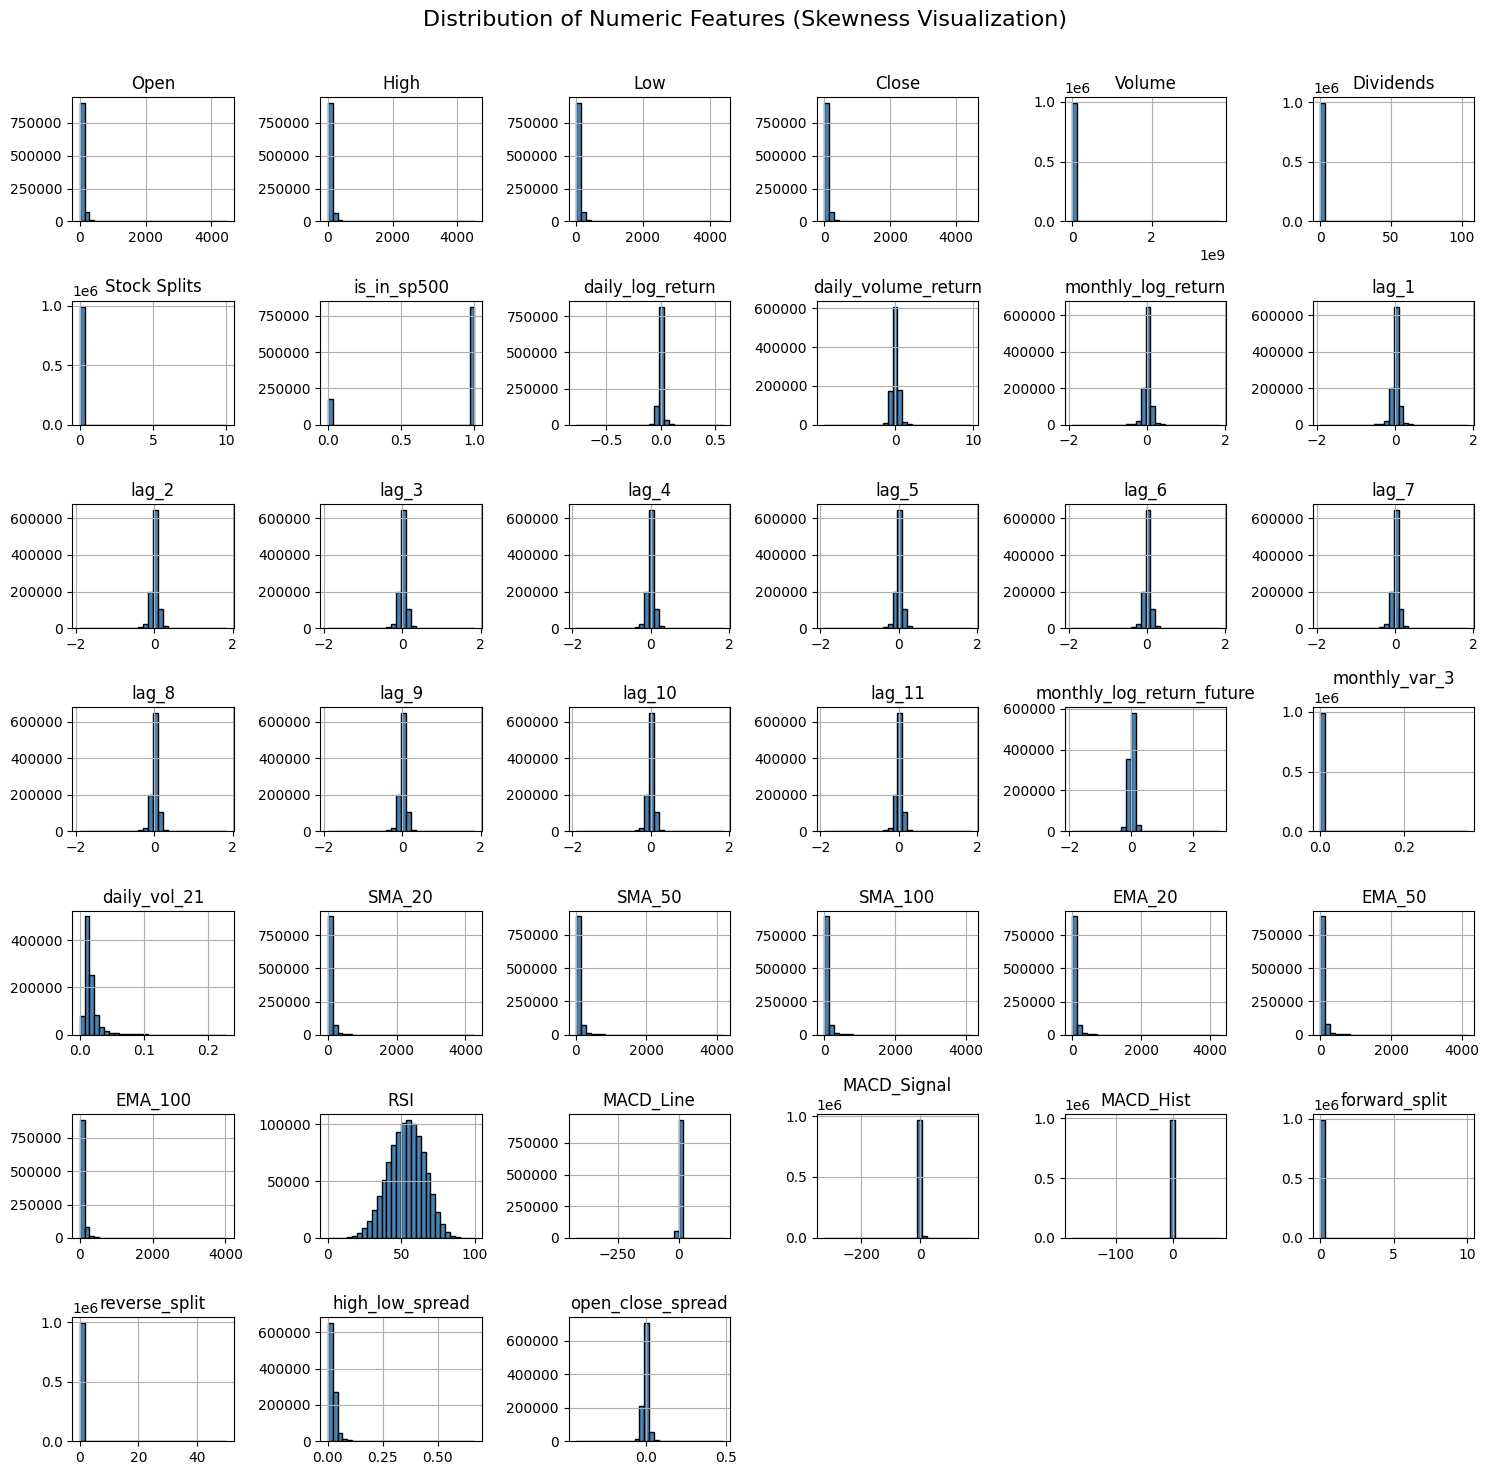

In [30]:
# Skewness checks
df_plot = SP500_all_stock_data_final.replace([np.inf, -np.inf], np.nan).dropna() # remove inf values if any

numeric_cols = df_plot.select_dtypes(include=[np.number]).columns

df_plot[numeric_cols].hist(
    bins=30,
    figsize=(15, 15),
    edgecolor='black',
    color='steelblue'
)

plt.suptitle("Distribution of Numeric Features (Skewness Visualization)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [31]:
from scipy.stats import skew
import numpy as np
merged_log = SP500_all_stock_data_final[SP500_all_stock_data_final['ticker'] == 'AAPL']

# Select numeric columns
numeric_cols = merged_log.select_dtypes(include=[np.number]).columns

# Compute skewness
skew_vals = merged_log[numeric_cols].apply(lambda x: skew(x.dropna()))
skew_df = pd.DataFrame({"feature": skew_vals.index, "skew": skew_vals.values})
skew_df = skew_df.sort_values(by="skew", ascending=False)

print(skew_df)

                      feature       skew
35              forward_split  34.802556
6                Stock Splits  34.802556
5                   Dividends   8.314373
23              monthly_var_3   4.542352
37            high_low_spread   2.914408
4                      Volume   2.593618
24               daily_vol_21   2.530244
1                        High   1.735462
0                        Open   1.731715
3                       Close   1.723551
2                         Low   1.714323
25                     SMA_20   1.695600
28                     EMA_20   1.693827
26                     SMA_50   1.677175
29                     EMA_50   1.658905
27                    SMA_100   1.596228
30                    EMA_100   1.577764
33                MACD_Signal   1.475931
32                  MACD_Line   1.451852
9         daily_volume_return   0.282057
38          open_close_spread   0.234675
31                        RSI  -0.053483
8            daily_log_return  -0.482889
21              

/var/folders/sr/m5w47sf11d525m54586gg3c00000gn/T/ipykernel_64867/666708876.py:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_vals = merged_log[numeric_cols].apply(lambda x: skew(x.dropna()))


In [32]:
# Volume
SP500_all_stock_data_final['volume_log'] = np.log1p(SP500_all_stock_data_final['Volume'])

# Volatility/variance (from log returns), clipping to avoid log(0)
eps = 1e-12
SP500_all_stock_data_final['log_daily_vol_21']  = np.log(SP500_all_stock_data_final['daily_vol_21'].clip(lower=eps))
SP500_all_stock_data_final['log_monthly_var_3'] = np.log(SP500_all_stock_data_final['monthly_var_3'].clip(lower=eps))

# Prices & MAs → ratios (then drop raw) https://anderson-review.ucla.edu/wp-content/uploads/2021/03/Avramov-Kaplanski-Subra_2018_SSRN-id3111334.pdf?
for span in [20, 50, 100]:
    SP500_all_stock_data_final[f'close_sma_ratio_{span}'] = (SP500_all_stock_data_final['Close'] - SP500_all_stock_data_final[f'SMA_{span}']) / SP500_all_stock_data_final[f'SMA_{span}']
    SP500_all_stock_data_final[f'close_ema_ratio_{span}'] = (SP500_all_stock_data_final['Close'] - SP500_all_stock_data_final[f'EMA_{span}'])/ SP500_all_stock_data_final[f'EMA_{span}']


# MACD normalized by price
SP500_all_stock_data_final['macd_line_pct']   = SP500_all_stock_data_final['MACD_Line']   / SP500_all_stock_data_final['Close']
SP500_all_stock_data_final['macd_signal_pct'] = SP500_all_stock_data_final['MACD_Signal'] / SP500_all_stock_data_final['Close']
SP500_all_stock_data_final['macd_hist_pct']   = SP500_all_stock_data_final['MACD_Hist']   / SP500_all_stock_data_final['Close']



/var/folders/sr/m5w47sf11d525m54586gg3c00000gn/T/ipykernel_64867/898043066.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SP500_all_stock_data_final['volume_log'] = np.log1p(SP500_all_stock_data_final['Volume'])
/var/folders/sr/m5w47sf11d525m54586gg3c00000gn/T/ipykernel_64867/898043066.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SP500_all_stock_data_final['log_daily_vol_21']  = np.log(SP500_all_stock_data_final['daily_vol_21'].clip(lower=eps))
/var/folders/sr/m5w47sf11d525m54586gg3c00000gn/T/ip

In [33]:
valid_cols = [
    col for col in numeric_cols
    if merged_log[col].nunique() > 1 and np.isfinite(merged_log[col]).all()
]

def safe_skew(series):
    vals = series.dropna()
    return skew(vals) if vals.nunique() > 1 else np.nan

skew_vals = merged_log[valid_cols].apply(safe_skew)

# Create sorted DataFrame of results
skew_df = (
    pd.DataFrame({"feature": skew_vals.index, "skew": skew_vals.values})
    .dropna()
    .sort_values(by="skew", ascending=False)
    .reset_index(drop=True)
)

In [34]:
# Create sorted DataFrame of results
skew_df = (
    pd.DataFrame({"feature": skew_vals.index, "skew": skew_vals.values})
    .dropna()
    .sort_values(by="skew", ascending=False)
    .reset_index(drop=True)
)

display(skew_df)

,feature,skew
0,forward_split,34.802556
1,Stock Splits,34.802556
2,Dividends,8.314373
3,monthly_var_3,4.542352
4,high_low_spread,2.914408
5,Volume,2.593618
6,daily_vol_21,2.530244
7,High,1.735462
8,Open,1.731715
9,Close,1.723551


In [35]:
#Drop raw columns that cause skew / redundancy
to_drop = [
    'Open','High','Low','Close', # dropping raw prices them as calculated fields
    'SMA_20','SMA_50','SMA_100','EMA_20','EMA_50','EMA_100', # dropping raw moving averages we have them as pct
    'Volume','daily_vol_21','monthly_var_3', # changed to log versions 
    'MACD_Line','MACD_Signal','MACD_Hist', # dropping raw MACD we have them as pct
    'Stock Splits', 'monthly_log_return'    # we shift monthly_log_return forward so drop current
]
SP500_all_stock_data_final = SP500_all_stock_data_final.drop(columns=[c for c in to_drop if c in SP500_all_stock_data_final.columns], errors='ignore')

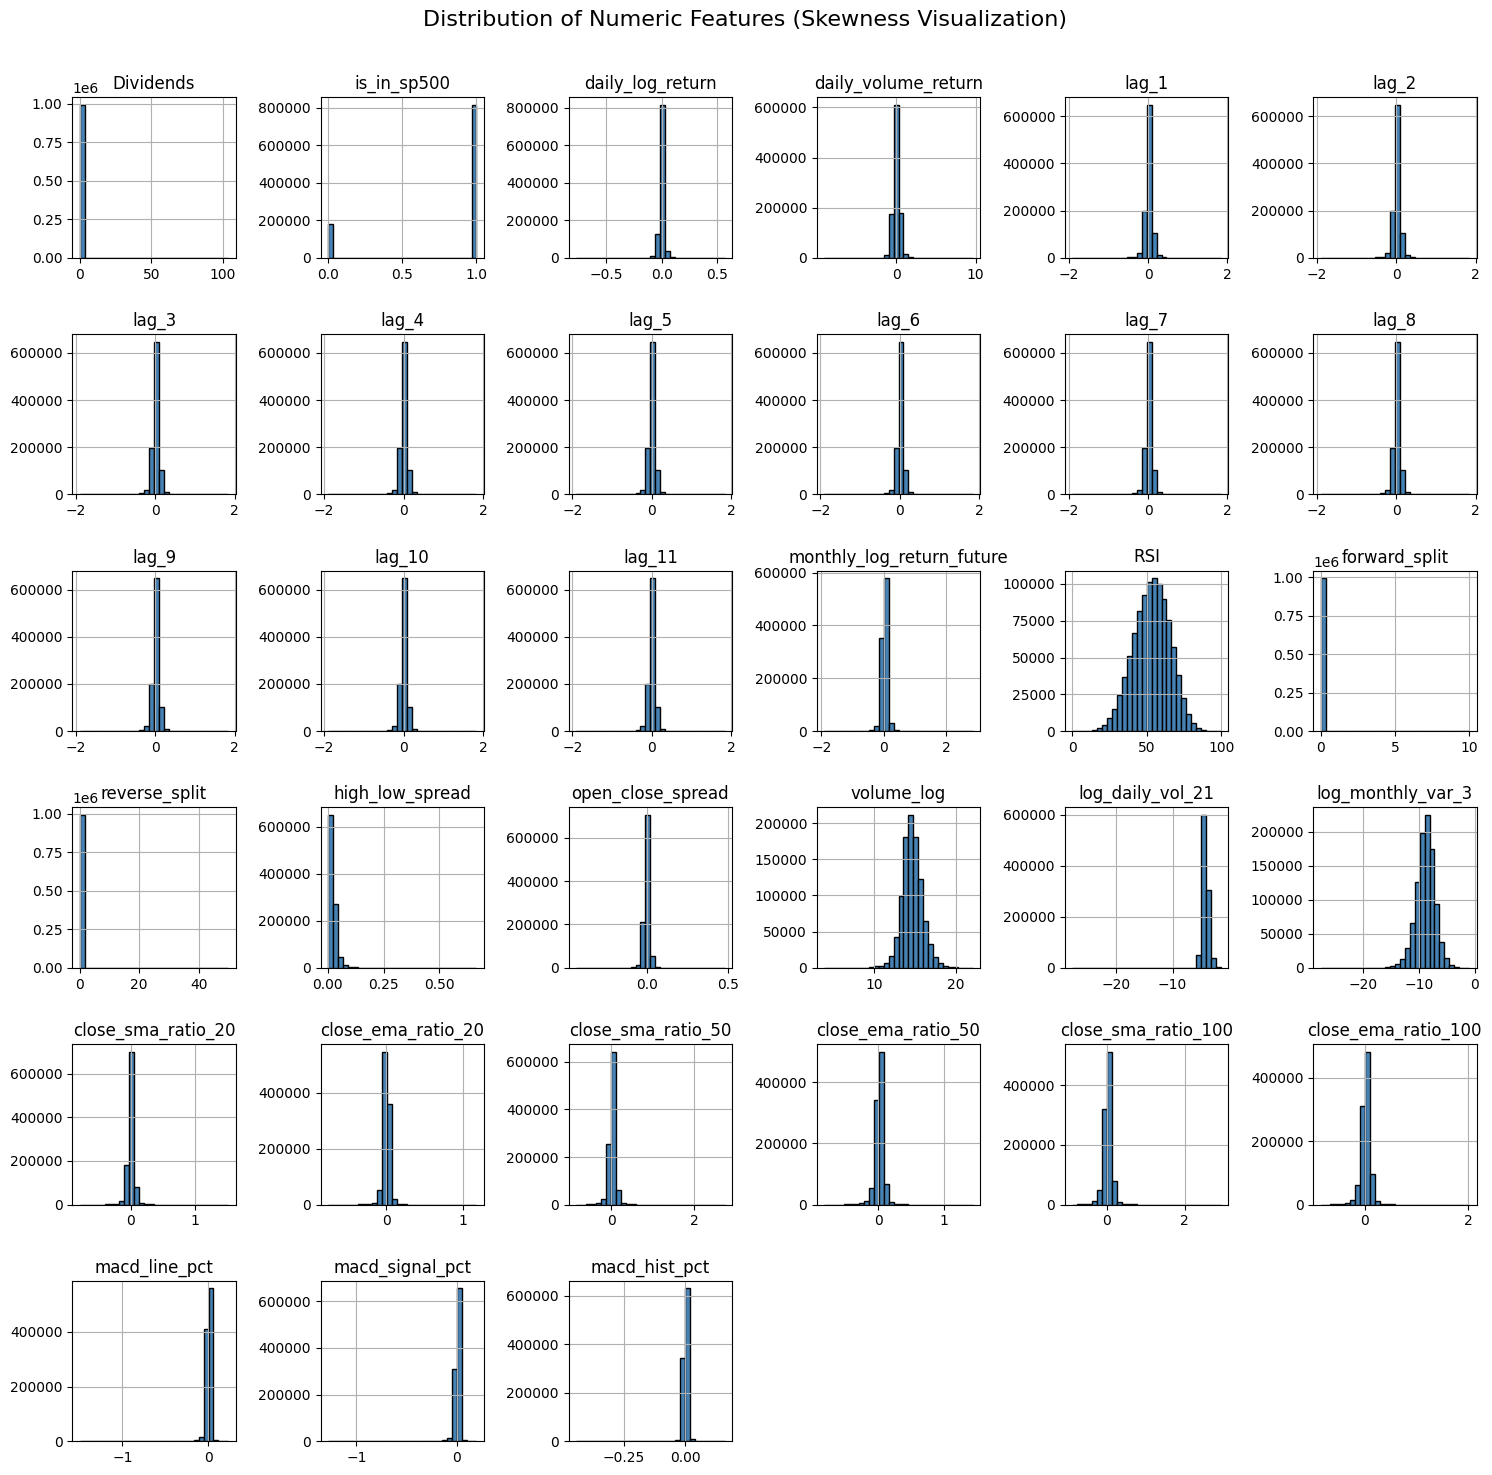

In [36]:
# Skewness checks
df_plot = SP500_all_stock_data_final.replace([np.inf, -np.inf], np.nan).dropna() # remove inf values if any

numeric_cols = df_plot.select_dtypes(include=[np.number]).columns

df_plot[numeric_cols].hist(
    bins=30,
    figsize=(15, 15),
    edgecolor='black',
    color='steelblue'
)

plt.suptitle("Distribution of Numeric Features (Skewness Visualization)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

#### Stationarity checks
we will use ADF and KPSS test for stationarity checks and eliminate serial correlation through transformations if required

In [37]:
from statsmodels.tsa.stattools import adfuller, kpss
import numpy as np

In [38]:
def check_adf_all_columns(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    results = []

    for col in numeric_cols:
        series = df[col].dropna()

        adf_p = np.nan
        adf_verdict = "error"
        kpss_p = np.nan
        kpss_verdict = "error"
        combined_verdict = "inconclusive"

        # ADF Test
        try:
            p_val = adfuller(series, autolag="AIC")[1]  # uses AIC to determine optimal lags
            adf_p = p_val
            adf_verdict = "stationary" if p_val < 0.05 else "non_stationary"
        except Exception as e:
            adf_p = np.nan
            adf_verdict = f"adf_error: {e}"

        # KPSS Test
        # logic is inverted due to h0 being stationary for KPSS in contrast to ADF 
        try:
            kpss_res = kpss(series, regression="c", nlags="auto")  # c is chosen to test for level stationarity, auto will use newey-west lags
            kpss_p = kpss_res[1]
            kpss_verdict = "stationary" if kpss_p >= 0.05 else "non_stationary"
        except Exception as e:
            kpss_p = np.nan
            kpss_verdict = f"kpss_error: {e}"

        # Combine ADF and KPSS results verdict
        if isinstance(adf_verdict, str) and isinstance(kpss_verdict, str):
            if adf_verdict == "stationary" and kpss_verdict == "stationary":
                combined_verdict = "stationary"
            elif adf_verdict == "non_stationary" and kpss_verdict == "non_stationary":
                combined_verdict = "non_stationary"
            elif adf_verdict.startswith("adf_error") or kpss_verdict.startswith("kpss_error"):
                combined_verdict = "inconclusive"
            else:
                # Disagreement → flag for manual review (trend, breaks, low power, etc.)
                combined_verdict = "ambiguous"

        results.append({
            "column": col,
            # ADF
            "ADF_p": adf_p,
            "ADF_Verdict": adf_verdict,
            # KPSS
            "KPSS_p": kpss_p,
            "KPSS_Verdict": kpss_verdict,
            # Combined
            "Combined_Verdict": combined_verdict
        })

    return pd.DataFrame(results)

In [39]:
# Using only one stock (appl) for ADF because my kernel keeps crashing and its computationally expensive :"
appl_stock_data = SP500_all_stock_data_final[SP500_all_stock_data_final['ticker'] == 'AAPL']
adf_results = check_adf_all_columns(appl_stock_data)
display(adf_results)


/var/folders/sr/m5w47sf11d525m54586gg3c00000gn/T/ipykernel_64867/3292298288.py:26: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(series, regression="c", nlags="auto")  # c is chosen to test for level stationarity, auto will use newey-west lags
/Users/ash/Documents/School/Y4S1/DSE4212/project/DSE4212-Portfolio-Optimiser/.venv/lib/python3.14/site-packages/statsmodels/tsa/stattools.py:2182: RuntimeWarning: invalid value encountered in scalar divide
  s_hat = s1 / s0
/var/folders/sr/m5w47sf11d525m54586gg3c00000gn/T/ipykernel_64867/3292298288.py:26: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(series, regression="c", nlags="auto")  # c is chosen to test for level stationarity, auto will use newey-west lags
/var/folde

,column,ADF_p,ADF_Verdict,KPSS_p,KPSS_Verdict,Combined_Verdict
0,Dividends,0.000000e+00,stationary,0.100000,stationary,stationary
1,is_in_sp500,NaN,"adf_error: Invalid input, x is constant",NaN,kpss_error: cannot convert float NaN to integer,inconclusive
2,daily_log_return,1.231315e-26,stationary,0.100000,stationary,stationary
3,daily_volume_return,1.080080e-26,stationary,0.100000,stationary,stationary
4,lag_1,7.722549e-09,stationary,0.100000,stationary,stationary
5,lag_2,1.103655e-08,stationary,0.100000,stationary,stationary
6,lag_3,1.367366e-08,stationary,0.100000,stationary,stationary
7,lag_4,9.100192e-09,stationary,0.100000,stationary,stationary
8,lag_5,7.554511e-09,stationary,0.100000,stationary,stationary
9,lag_6,1.210369e-08,stationary,0.100000,stationary,stationary


In [40]:
SP500_all_stock_data_final.isna().sum()

Date                         0
Dividends                    0
ticker                       0
is_in_sp500                  0
daily_log_return             0
daily_volume_return          0
lag_1                        0
lag_2                        0
lag_3                        0
lag_4                        0
lag_5                        0
lag_6                        0
lag_7                        0
lag_8                        0
lag_9                        0
lag_10                       0
lag_11                       0
monthly_log_return_future    0
RSI                          0
forward_split                0
reverse_split                0
high_low_spread              0
open_close_spread            0
volume_log                   0
log_daily_vol_21             0
log_monthly_var_3            0
close_sma_ratio_20           0
close_ema_ratio_20           0
close_sma_ratio_50           0
close_ema_ratio_50           0
close_sma_ratio_100          0
close_ema_ratio_100          0
macd_lin

#### Covid hold out set 
https://en.wikipedia.org/wiki/2020_stock_market_crash#:~:text=Though%20the%20crash%20began%20on,13%25%20in%20most%20global%20markets.

Covid stock crash happened on: 20 Feb
we will use 2013-01-01 to 2020-02-19 data as our training test set and 2020-02-19 to 2020-12-12 as our holdout set

Purging will happen later using 100 days during time-series CV

In [41]:
# splitting the data appropriately into training, test and covid stress test data 
# Covid start https://en.wikipedia.org/wiki/2020_stock_market_crash#:~:text=Though%20the%20crash%20began%20on,13%25%20in%20most%20global%20markets.
COVID_start_date = '2020-02-20'
training_data =  SP500_all_stock_data_final[SP500_all_stock_data_final['Date'] < pd.to_datetime(COVID_start_date)]
covid_stress_test_data = SP500_all_stock_data_final[SP500_all_stock_data_final['Date'] >= pd.to_datetime(COVID_start_date)]

In [42]:
# checking the newly listed stocks in the training data
first_trade_training = training_data.groupby("ticker")["Date"].min().reset_index()
first_trade_training["Date"] = pd.to_datetime(first_trade_training["Date"])
first_trade_training.columns = ["ticker", "first_trade_date"]
first_trade_training.query("first_trade_date >= '2013-01-01'")

,ticker,first_trade_date
0,A,2013-01-02
1,AAL,2013-01-02
2,AAP,2013-01-02
3,AAPL,2013-01-02
4,ABBV,2013-05-24
...,...,...
500,YUM,2013-01-02
501,ZBH,2013-01-02
502,ZBRA,2013-01-02
503,ZION,2013-01-02


In [43]:
training_data.columns

Index(['Date', 'Dividends', 'ticker', 'is_in_sp500', 'daily_log_return',
       'daily_volume_return', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
       'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11',
       'monthly_log_return_future', 'RSI', 'forward_split', 'reverse_split',
       'high_low_spread', 'open_close_spread', 'volume_log',
       'log_daily_vol_21', 'log_monthly_var_3', 'close_sma_ratio_20',
       'close_ema_ratio_20', 'close_sma_ratio_50', 'close_ema_ratio_50',
       'close_sma_ratio_100', 'close_ema_ratio_100', 'macd_line_pct',
       'macd_signal_pct', 'macd_hist_pct'],
      dtype='object')

In [44]:
training_data[(training_data['is_in_sp500'] != 1) & (training_data['ticker'] == 'TSLA')]

,Date,Dividends,ticker,is_in_sp500,daily_log_return,daily_volume_return,lag_1,lag_2,lag_3,lag_4,...,log_monthly_var_3,close_sma_ratio_20,close_ema_ratio_20,close_sma_ratio_50,close_ema_ratio_50,close_sma_ratio_100,close_ema_ratio_100,macd_line_pct,macd_signal_pct,macd_hist_pct
1134317,2013-01-02,0.0,TSLA,0,0.043051,0.697341,0.005329,-0.000301,0.046789,0.040090,...,-7.424715,0.033540,0.042919,0.099687,0.082627,0.152865,0.117732,0.013565,0.017196,-0.003631
1134318,2013-01-03,0.0,TSLA,0,-0.016826,-0.476385,0.044529,0.005329,-0.000301,0.046789,...,-7.550809,0.015005,0.023031,0.076831,0.061874,0.131534,0.096930,0.014235,0.016837,-0.002603
1134319,2013-01-04,0.0,TSLA,0,-0.010699,-0.096119,0.004323,0.044529,0.005329,-0.000301,...,-7.737808,0.003193,0.010975,0.060995,0.048495,0.117678,0.083428,0.013714,0.016357,-0.002644
1134320,2013-01-07,0.0,TSLA,0,-0.001746,-0.421920,0.014641,0.004323,0.044529,0.005329,...,-9.829874,0.000801,0.008327,0.054921,0.044754,0.114136,0.079795,0.012913,0.015691,-0.002779
1134321,2013-01-08,0.0,TSLA,0,-0.019407,1.066426,0.018516,0.014641,0.004323,0.044529,...,-8.614431,-0.017732,-0.010010,0.031294,0.023684,0.091833,0.057805,0.010794,0.014958,-0.004164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1136107,2020-02-12,0.0,TSLA,0,-0.009198,0.027405,0.482138,0.471478,0.418733,0.467955,...,-5.754160,0.179965,0.147900,0.519677,0.406117,0.928027,0.715725,0.108249,0.100515,0.007734
1136108,2020-02-13,0.0,TSLA,0,0.046734,0.782382,0.379733,0.482138,0.471478,0.418733,...,-5.842039,0.209859,0.180026,0.563332,0.446536,0.992070,0.769851,0.104049,0.097551,0.006498
1136109,2020-02-14,0.0,TSLA,0,-0.004950,-0.515903,0.401889,0.379733,0.482138,0.471478,...,-7.214100,0.178478,0.155037,0.528050,0.415011,0.955163,0.734964,0.103562,0.099140,0.004422
1136110,2020-02-18,0.0,TSLA,0,0.070421,0.042906,0.433709,0.401889,0.379733,0.482138,...,-5.705473,0.232869,0.211692,0.607280,0.488009,1.065745,0.830320,0.100112,0.093941,0.006171


In [45]:
covid_stress_test_data[covid_stress_test_data['ticker'] == 'TSLA']

,Date,Dividends,ticker,is_in_sp500,daily_log_return,daily_volume_return,lag_1,lag_2,lag_3,lag_4,...,log_monthly_var_3,close_sma_ratio_20,close_ema_ratio_20,close_sma_ratio_50,close_ema_ratio_50,close_sma_ratio_100,close_ema_ratio_100,macd_line_pct,macd_signal_pct,macd_hist_pct
1136112,2020-02-20,0.0,TSLA,0,-0.019826,-0.365774,0.586175,0.513840,0.433709,0.401889,...,-6.098006,0.229936,0.207866,0.614504,0.493150,1.096547,0.849815,0.104967,0.094755,0.010212
1136113,2020-02-21,0.0,TSLA,0,0.001766,-0.208586,0.496925,0.586175,0.513840,0.433709,...,-5.453178,0.205020,0.186276,0.585400,0.467262,1.068484,0.822302,0.105753,0.096821,0.008932
1136114,2020-02-24,0.0,TSLA,0,-0.077524,0.059488,0.458641,0.496925,0.586175,0.513840,...,-5.576369,0.095429,0.087656,0.442519,0.339023,0.888480,0.663754,0.107367,0.105174,0.002193
1136115,2020-02-25,0.0,TSLA,0,-0.041482,0.129375,0.376493,0.458641,0.496925,0.586175,...,-5.713641,0.034480,0.039160,0.362815,0.270433,0.789244,0.577527,0.101617,0.108026,-0.006409
1136116,2020-02-26,0.0,TSLA,0,-0.026745,-0.205011,0.347992,0.376493,0.458641,0.496925,...,-7.639328,-0.006434,0.010606,0.308168,0.225520,0.721399,0.519768,0.092733,0.107310,-0.014577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1136325,2020-12-22,0.0,TSLA,1,-0.014758,-0.115457,0.263610,0.356387,0.395581,0.422690,...,-5.903821,0.041299,0.056853,0.265666,0.202717,0.423875,0.401902,0.069645,0.072434,-0.002788
1136326,2020-12-23,0.0,TSLA,1,0.008769,-0.444031,0.268390,0.263610,0.356387,0.395581,...,-6.982075,0.042789,0.059486,0.266832,0.203245,0.425355,0.402743,0.065637,0.070568,-0.004931
1136327,2020-12-24,0.0,TSLA,1,0.024150,-0.372103,0.213388,0.268390,0.263610,0.356387,...,-6.123037,0.060763,0.076628,0.287673,0.221511,0.448550,0.424702,0.062644,0.067636,-0.004992
1136328,2020-12-28,0.0,TSLA,1,0.002897,0.344771,0.175266,0.213388,0.268390,0.263610,...,-6.752216,0.057238,0.071613,0.280702,0.214338,0.441185,0.416804,0.060867,0.066126,-0.005259


In [46]:
training_data = training_data.replace([np.inf, -np.inf], np.nan).dropna()
training_data.to_csv("processed_data/training_data.csv", index=False)

covid_stress_test_data = covid_stress_test_data.replace([np.inf, -np.inf], np.nan).dropna()
covid_stress_test_data.to_csv("processed_data/covid_stress_test_data.csv", index=False)
